# **NLP Project Title - IMDb Movie Review Sentiment Analysis**

The primary objective of this project is to build a machine learning classification model that
can predict the sentiment of IMDb movie reviews. The dataset contains a collection of movie
reviews, and each review is labeled as either positive or negative.

Using text preprocessing, feature extraction techniques (such as TF-IDF), and various
classification algorithms, the project will aim to develop a model that can effectively classify
the sentiment of movie reviews. The model's performance will be evaluated using standard
classification metrics, such as accuracy, precision, recall, and F1-score.

### ***1. Importing the necessary libraries***

In [ ]:
!pip install gensim

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
import gensim
from gensim import corpora
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### ***2. Importing the dataset***

In [ ]:
df=pd.read_csv('/content/Imdb - data_imdb.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


***2.1. Checking the datatype and non-null counts***: The dataset has
 no null values present.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


***2.2. Checking whether the sentiment values contains any other values except positive and negative.***

In [ ]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


***2.3. Review length analysis and outliers detection***

In [ ]:
df['review_length']=df['review'].str.len()
df['review_length'].min()


7

In [ ]:
df['review_length'].max()

13704

In [ ]:
df['review_length'].mean()

1309.36772

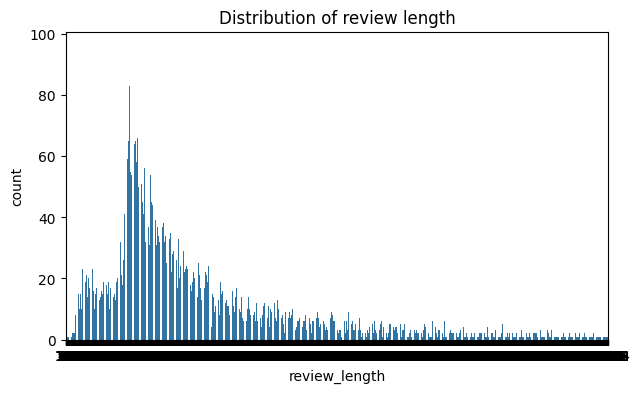

In [ ]:
plt.figure(figsize=(7,4))
sns.countplot(x='review_length', data=df)
plt.title("Distribution of review length")
plt.show()

**Insights**:

The review length distribution is right-skewed, with most reviews being short and a few lengthy outliers. I decided not to remove any reviews to maintain the original variety in user feedback and allow the model to learn from all review patterns.

### ***3. Visualizing the distribution of sentiment***

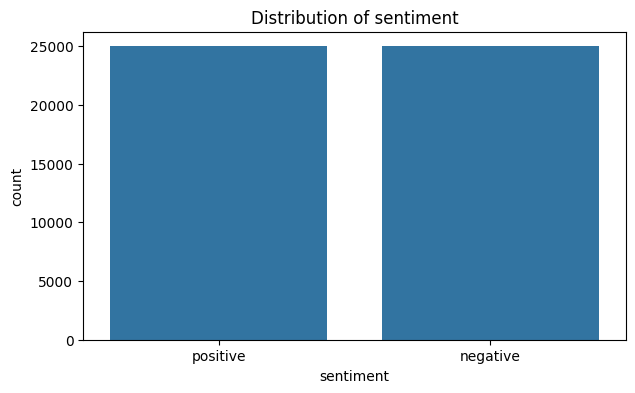

In [ ]:
plt.figure(figsize=(7,4))
sns.countplot(x='sentiment', data=df)
plt.title("Distribution of sentiment")
plt.show()

**Insights**:

* Balanced IMDb dataset with equal number of positive and negative reviews, great for model training.
* Classifier model won’t be biased toward one sentiment.
* Each sentiment has roughly 50% of the total reviews, which ensures fair learning.

### ***4. Preprocessing the dataset***

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    # 1. Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # 2. Remove non-letter characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # 3. Convert to lowercase
    text = text.lower()

   # 4. Tokenize words
    tokens = word_tokenize(text)

    # 5. Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # 6. Join tokens back to string
    return ' '.join(tokens)

In [ ]:
df['clean_review'] = df['review'].apply(preprocess_text)

In [ ]:
df[['review', 'clean_review']].head()

,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visually stunnin...


***Word Clouds***

Word clouds help you visualize the most frequent words in positive and negative reviews.

In [ ]:
pip install wordcloud

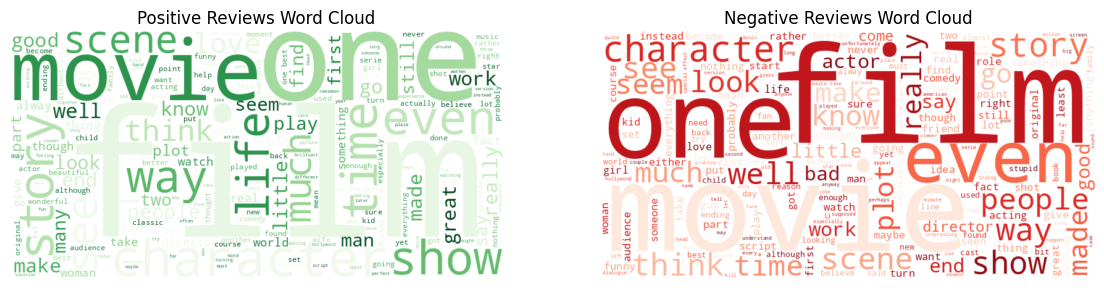

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate positive and negative reviews
positive_text = " ".join(df[df['sentiment'] == 'positive']['clean_review'])
negative_text = " ".join(df[df['sentiment'] == 'negative']['clean_review'])

# Create word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Plot them side by side
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews Word Cloud")

plt.subplot(1,2,2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews Word Cloud")

plt.show()


### ***5. Spliting the data***

In [ ]:
le = LabelEncoder()
x=df['clean_review']
y=le.fit_transform(df['sentiment'])

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

### ***6. Feature Engineering***

***6.1. Bag of Words(BOWs)***

Counts the frequency of each word in a document, ignoring grammar and word order.

In [ ]:
bow = CountVectorizer(max_features=5000)
x_train_bow = bow.fit_transform(x_train)
x_test_bow = bow.transform(x_test)

***6.2. Word2Vec***

Creates dense vector representations of words based on their context, capturing semantic relationships (meaning) between words.

In [ ]:
 # Step 1: Tokenize reviews
tokenized_reviews = [review.split() for review in df['clean_review']]

# Step 2: Train Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_reviews,
    vector_size=100,   # size of word vectors
    window=5,          # context window
    min_count=2,       # ignore rare words
    workers=4,         # number of CPU cores
    sg=1               # skip-gram model (better for small data)
)

# Step 3: Create average Word2Vec vector for each review
def get_vector(tokens):
    vec = np.zeros(100)
    count = 0
    for word in tokens:
        if word in w2v_model.wv:
            vec += w2v_model.wv[word]
            count += 1
    return vec / count if count > 0 else vec

df['review_vector'] = [get_vector(tokens) for tokens in tokenized_reviews]
df['review_vector']



,review_vector
0,"[-0.047275600506475675, 0.11900835210762137, -..."
1,"[0.0039857769960208855, 0.1781138696392779, 0...."
2,"[-0.10558034061077273, 0.18832797147860264, 0...."
3,"[-0.09538950341084274, 0.10685292158450466, 0...."
4,"[-0.03568081401867747, 0.1065082330771578, 0.0..."
...,...
49995,"[-0.1645238372291644, 0.19526834876349122, -0...."
49996,"[-0.20267091135610826, 0.1923565694264003, 0.0..."
49997,"[-0.12434880372829142, 0.1022075270271687, 0.0..."
49998,"[0.0010312777968855308, 0.11561584000342659, 0..."


***6.3. TFidf vectorizer***

Weighs word frequency by its rarity across the entire collection, emphasizing unique and important words.

In [ ]:
# Choose max_features to limit the vocabulary size (e.g., 5000 or 10000)
# Use n-grams (1, 2) to capture single words and two-word phrases (e.g., "not good")

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
x_train_tfidf= vectorizer.fit_transform(x_train)
x_test_tfidf=vectorizer.transform(x_test)


***6.4. Textual (Statistical) Features***

Simple, quantifiable metrics (like word count, character count, or average word length) that capture the structural style and complexity of the text.

In [ ]:
# Word count
df['word_count'] = df['clean_review'].apply(lambda x: len(x.split()))

# Character count
df['char_count'] = df['clean_review'].apply(lambda x: len(x))

# Average word length
df['avg_word_length'] = df['clean_review'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0
)

***6.5. Combining TF-IDF features with textual features***

TF-IDF features capture the textual content, while additional textual statistics describe the structure and writing style of reviews. By combining both, the model gains a richer representation of sentiment, leading to improved accuracy and generalization.

***Spliting the textual features to match train-test split***

In [ ]:
# Textual features dataframe
text_features = df[['word_count', 'char_count', 'avg_word_length']]

# Split them according to the same indices as TF-IDF
x_train_text = text_features.loc[x_train.index]
x_test_text = text_features.loc[x_test.index]


In [ ]:
from scipy.sparse import hstack

# Combine TF-IDF with textual features
x_train_combined = hstack([x_train_tfidf, x_train_text])
x_test_combined = hstack([x_test_tfidf, x_test_text])


**Using TF-IDF and Textual Features over Word2Vec**:

* **Simplicity & Speed**: TF-IDF is faster to compute, making it ideal for large datasets like IMDb.

* **Works Well with Linear Models**: Logistic Regression performs best with sparse, high-dimensional TF-IDF features.

* **Captures Word Importance**: TF-IDF highlights key sentiment words, improving classification.

* **Adds Context**: Features like word count or punctuation convey extra information (e.g., emotion) that Word2Vec ignores.

**Cons of Word2Vec**:

* Requires aggregation, losing word order.

* Basic Word2Vec with simple models often underperforms TF-IDF.

### ***7. Model Development***

### ***7.1. Neutral Network Model (LSTM)***

**Step 1: Tokenized, Padded Text then Built and Trained LSTM Model**

Neural networks don’t use TF-IDF — they need sequences of integers.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Encode labels

df['sentiment'] = le.fit_transform(df['sentiment'])  # 0 = negative, 1 = positive

# Tokenize
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_review'])
sequences = tokenizer.texts_to_sequences(df['clean_review'])
padded = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

# Split
X_train, X_test, Y_train, Y_test = train_test_split(padded, df['sentiment'], test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# Compile with small learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                    epochs=3, batch_size=128, verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 136s 419ms/step - accuracy: 0.5077 - loss: 0.6933 - val_accuracy: 0.5095 - val_loss: 0.6915
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 433ms/step - accuracy: 0.5419 - loss: 0.6785 - val_accuracy: 0.5223 - val_loss: 0.6843
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 131s 418ms/step - accuracy: 0.5457 - loss: 0.6702 - val_accuracy: 0.7108 - val_loss: 0.5991


**Step 2: Evaluation of the Model**

In [ ]:
Y_pred_prob = model.predict(X_test)
Y_pred = (Y_pred_prob > 0.5).astype(int).reshape(-1)

print("Accuracy:", accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))
roc_auc = roc_auc_score(Y_test, Y_pred_prob)
print("ROC–AUC:", roc_auc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step
Accuracy: 0.7108
              precision    recall  f1-score   support

           0       0.78      0.58      0.67      4961
           1       0.67      0.84      0.75      5039

    accuracy                           0.71     10000
   macro avg       0.73      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000

ROC–AUC: 0.7404750305008557


The LSTM model achieved an accuracy of 71.08% and a ROC–AUC of 0.74, indicating good overall discrimination between positive and negative reviews. However, recall for positive sentiment was lower, suggesting the model is slightly biased toward detecting negative reviews more effectively. Further tuning or balancing could improve sensitivity to positive sentiments.

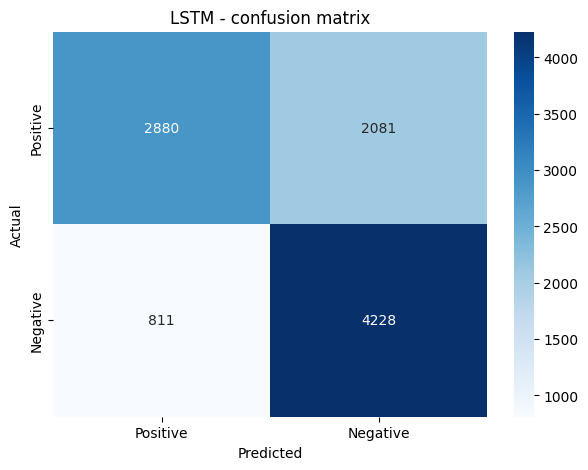

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(Y_test, Y_pred),annot=True, fmt='d', cmap='Blues', xticklabels=["Positive","Negative"], yticklabels=["Positive","Negative"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('LSTM - confusion matrix')
plt.show()

**Observation**:

* The model performs better on positive reviews than negative reviews.

* There is higher misclassification of negative reviews, which could be due to difficulty in capturing subtle negative sentiment patterns.

### ***7.2. Developed, trained, and evaluated the traditional models like Logistic regression, Naive Bayes, SVM, Random Forest.***

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression
Accuracy: 0.8895
ROC–AUC: 0.9580101653384592
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



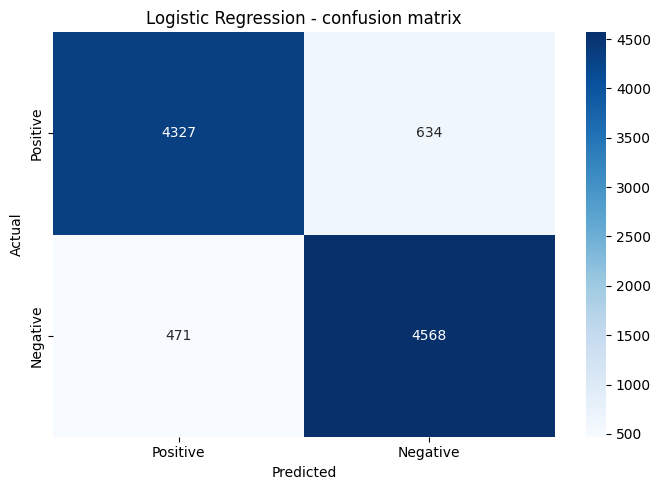


Naive Bayes
Accuracy: 0.8305
ROC–AUC: 0.9088242128651107
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4961
           1       0.83      0.84      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



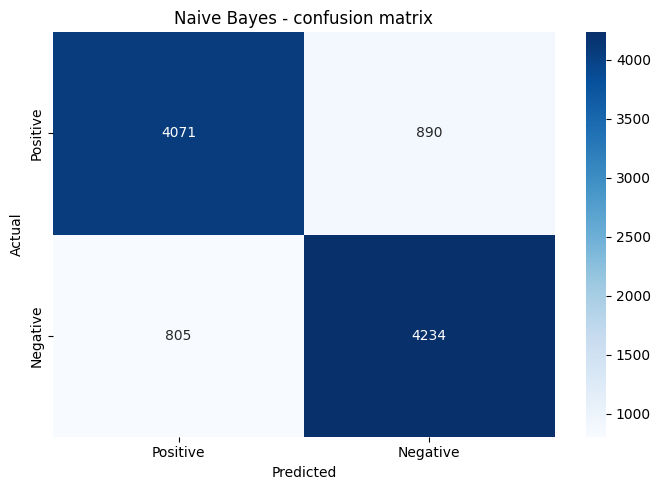


SVM
Accuracy: 0.8838
ROC–AUC: 0.9554932122070307
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.89      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



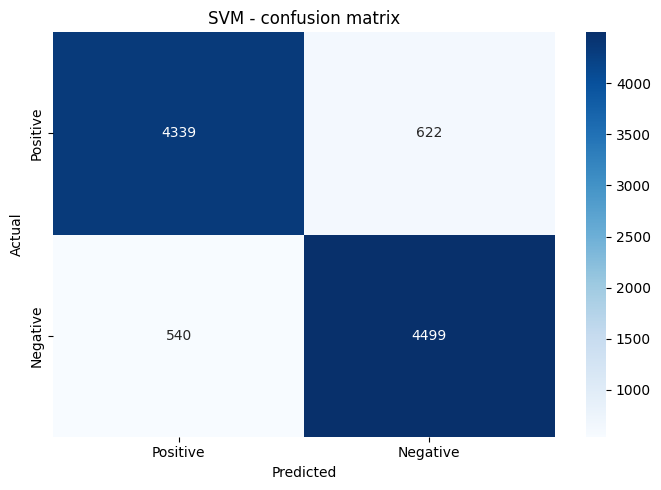


Random Forest
Accuracy: 0.8536
ROC–AUC: 0.9315401549030243
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      4961
           1       0.86      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



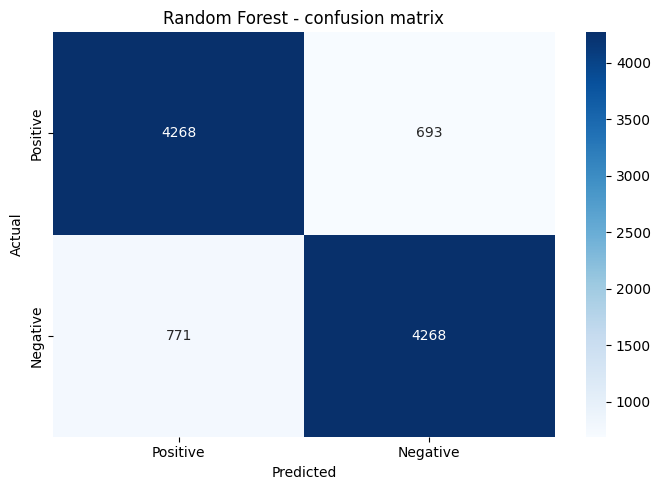

In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Store results
results = []

for name, model in models.items():
    model.fit(x_train_combined, y_train)
    y_pred = model.predict(x_test_combined)

    # For ROC–AUC, we need predicted probabilities (not supported by LinearSVC directly)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_test_combined)[:, 1]
    else:
        # For SVM, use decision_function instead
        y_proba = model.decision_function(x_test_combined)

    roc_auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n{name}")
    print("Accuracy:", acc)
    print("ROC–AUC:", roc_auc)
    print(classification_report(y_test, y_pred))

    results.append((name, acc, roc_auc))



    plt.figure(figsize=(7,5))
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True, fmt='d', cmap='Blues', xticklabels=["Positive","Negative"], yticklabels=["Positive","Negative"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f'{name} - confusion matrix')
    plt.tight_layout()
    plt.show()


***7.2.1. Visualizing the distribution of traditional models accuracy***

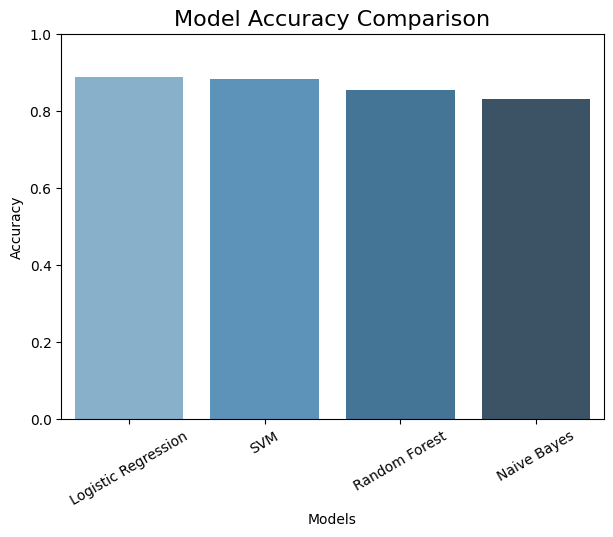

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC_AUC"])

# Sort by Accuracy (optional)
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Plot
plt.figure(figsize=(7, 5))
sns.barplot(data=results_df, x="Model", y="Accuracy", hue="Model", palette="Blues_d", legend=False)
plt.title("Model Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

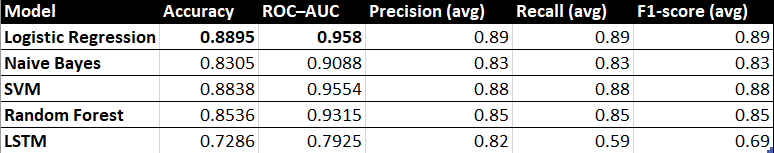

**Key** **Insights**:

* Logistic Regression performs best overall with the highest Accuracy (88.9%) and ROC–AUC (0.958). Indicates strong discriminative ability and stable generalization.

* SVM performs nearly as well (Accuracy 88.3%, ROC–AUC 0.955), showing it captures similar decision boundaries as Logistic Regression but with slightly lower recall.

* Naive Bayes performs decently (Accuracy 83%), but its probabilistic assumptions (word independence) limit performance on complex text.

* Random Forest performs moderately (Accuracy 85%), but slightly lags due to sparsity of TF–IDF features — tree-based models don’t handle high-dimensional sparse text data as efficiently as linear models.



### ***8. Model Deployment***

Deploying trained Logistic regression model as its accuracy is great comparing to other models.

Joblib is used to save and load trained models efficiently, allowing reuse without retraining. It’s fast and handles large NumPy arrays, making it ideal for storing ML models.

In [ ]:
import joblib
import pickle

lr_model = models["Logistic Regression"]
lr_model.fit(x_train_combined, y_train)
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(lr_model, "logistic_regression_model.pkl")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['logistic_regression_model.pkl']

In [38]:

# Load trained model and vectorizer
lrs_model = joblib.load("logistic_regression_model.pkl")
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Function to clean and preprocess review
def preprocess_review(review):
    review = re.sub(r"<br\s*/?>", " ", review)   # remove HTML tags
    review = re.sub(r"[^a-zA-Z]", " ", review)   # keep only letters
    review = review.lower().strip()
    return review

# Function to extract textual features
def extract_text_features_single(review):
    words = review.split()
    word_count = len(words)
    char_count = len(review)
    avg_word_length = np.mean([len(w) for w in words]) if word_count > 0 else 0
    return np.array([[word_count, char_count, avg_word_length]])

# Function to predict sentiment
def predict_sentiment(new_review):
    # Preprocess
    cleaned = preprocess_review(new_review)

    # TF-IDF transform
    tfidf_features = tfidf_vectorizer.transform([cleaned])

    # Textual features
    text_features = extract_text_features_single(cleaned)

    # Combine both
    combined_features = hstack([tfidf_features, text_features])

    # Predict

    prediction = lrs_model.predict(combined_features)[0]
    prob = lrs_model.predict_proba(combined_features)[0, 1]

    sentiment = "Positive" if prediction == 1 else "Negative"
    confidence = round(prob if prediction == 1 else 1 - prob, 3)

    return sentiment, confidence


***Results after deploying the model***

In [39]:
review = input("Enter the review:")
sentiment, confidence = predict_sentiment(review)
print("Sentiment:", sentiment)
print("Confidence:", confidence)


Enter the review:This film exceeded my expectations. The characters felt real, and the ending was powerful.
Sentiment: Positive
Confidence: 0.801


In [40]:
rev = input("Enter the review:")
sentiment, confidence = predict_sentiment(rev)
print("Sentiment:", sentiment)
print("Confidence:", confidence)

Enter the review:I didn’t connect with the story at all. It felt forced and unrealistic.
Sentiment: Negative
Confidence: 0.887


**Insights and conclusion**:

* The deployed model is working accurately, as seen in these examples: it correctly identifies positive reviews like “This film exceeded my expectations…” and negative reviews like “I didn’t connect with the story at all…” with high confidence (0.801 and 0.887, respectively).

* This performance reflects the choice of Logistic Regression, which achieved the best accuracy in this project. Using TF-IDF + textual features as the primary vectorization helped the model capture key sentiment words and contextual cues, making it reliable for predicting user reviews.